In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import requests

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

In [2]:
#defining functions useful to find the pdf of a given set of data

def kde_sklearn(data,xgrid, bandwidth = 1.0):
    kde_skl = KernelDensity(bandwidth = bandwidth)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(xgrid[:, np.newaxis]) #sklearn return the log(pdf)
    return np.exp(log_pdf)

def KDE_binning(x,xgrid):
    bwrange = np.linspace(0.01,1.0, 30) #bandwiths to test
    K = 5 #number of cross valdations
    grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) 
    grid.fit(x[:,None]) #fitting our data 
    h_opt = grid.best_params_['bandwidth'] #getting the best bandwidth
    pdf=kde_sklearn(x,xgrid,h_opt) #getting the pdf using the previous function
    return pdf


In [3]:
# Downloading file

r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Reading content

data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Reading headers

with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

#printing the names

print(names)

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [4]:
#getting data about T90 and flux 

T90=np.array(data[6],dtype=float)
fluence=np.array(data[9],dtype=float)

#creating some masks to getting rid of non useful data 

mask1=T90>0
mask2=fluence>0

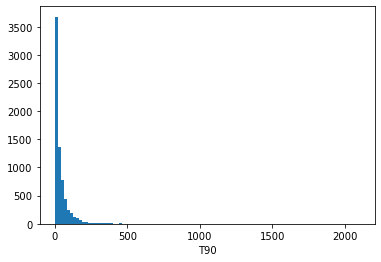

In [5]:
#getting the useful data of T90

time=T90[mask1]

#plotting an histogram just to take a look at the data

plt.hist(time,bins=100);
plt.xlabel('T90')
plt.show()

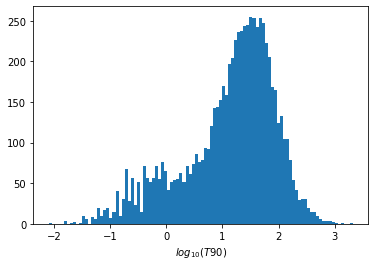

In [6]:
#Since the plot above doesn't tell much on how the data are distributed 
#here I plot an histogram taking the log10 of our data

plt.hist(np.log10(time),bins=100);
plt.xlabel(r'$log_{10}(T90)$')
plt.show()

0

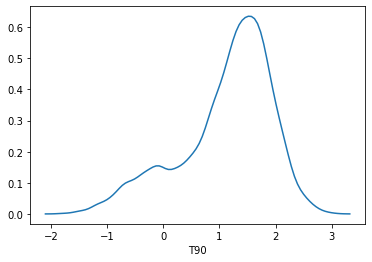

In [26]:
#using cross_validation and the functions defined above to evaluate the pdf 

xgrid=np.linspace(np.min(np.log10(time)),np.max(np.log10(time)),100)
pdf=KDE_binning(np.log10(time),xgrid)

#plotting

plt.plot(xgrid,pdf)
plt.xlabel('T90')

#Since this may take a while I added a sound to alert when the work is done

os.system('afplay /System/Library/Sounds/Blow.aiff')

## Clustering using K-means

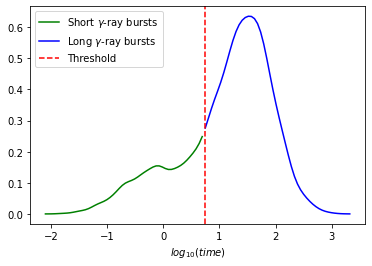

In [62]:
#Using K-means to cluster the data

#defining the number of clusters and the scaler

n_clusters=2
scaler = preprocessing.StandardScaler()

#fitting our data

clf = KMeans(n_clusters)
clf.fit(scaler.fit_transform(np.log10(time[:,None])))

# defining a condition to divide the two cluster and finding the threshold

condition= clf.predict(scaler.transform(xgrid[:,None]))==1
threshold=xgrid[np.where(condition==False)[0][0]]

#plotting distinguishing between the two clusters

plt.plot(xgrid[condition],pdf[condition],color='green', label=r'Short $\gamma$-ray bursts')
plt.plot(xgrid[~condition],pdf[~condition],color='blue', label=r'Long $\gamma$-ray bursts')
plt.axvline(threshold,color='red',linestyle='--',label='Threshold')

plt.xlabel(r'$log_{10}(time)$')
plt.legend()
plt.show()

## Clustering using Mean_Shift

bandwidth:  0.5194789818073049
number of estimated clusters : 2


<function matplotlib.pyplot.show(close=None, block=None)>

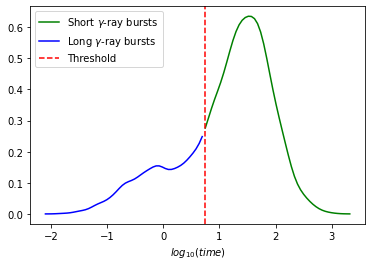

In [59]:
#Using Mean_shift to cluster the data

#defining the scaler and bandwith 

scaler = preprocessing.StandardScaler()

#I let sklearn decide the best bandwidth using 'estimate_bandwidth'

bandwidth = estimate_bandwidth(np.log10(time)[:,None]) 
print('bandwidth: ',bandwidth)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)

#fitting our data 

ms.fit(scaler.fit_transform(np.log10(time)[:,None]))

#finding the number of clusters 

labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print("number of estimated clusters :", n_clusters)

#finding the threshold between the two clusters 

condition_MS=ms.predict(scaler.transform(xgrid[:,None]))==0
threshold_MS=xgrid[np.where(condition_MS)[0][0]]

#plotting distinguishing between the two clusters

plt.plot(xgrid[condition_MS],pdf[condition_MS],color='green', label=r'Short $\gamma$-ray bursts')
plt.plot(xgrid[~condition_MS],pdf[~condition_MS],color='blue', label=r'Long $\gamma$-ray bursts')
plt.axvline(threshold_MS,color='red',linestyle='--',label='Threshold')
plt.xlabel(r'$log_{10}(time)$')
plt.legend()
plt.show

## Time and flux

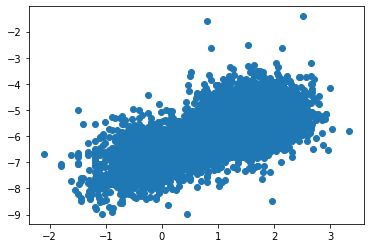

In [63]:
#making a mask that takes into account the bad values on both time and flux

mask=mask1 & mask2

#defining vectors with the useful data

flux=fluence[mask]
time=T90[mask]

#plotting data in a scatter plot

plt.scatter(np.log10(time),np.log10(flux))

bandwidth:  29.694418405404473
labels:  [0 1]
number of estimated clusters : 2


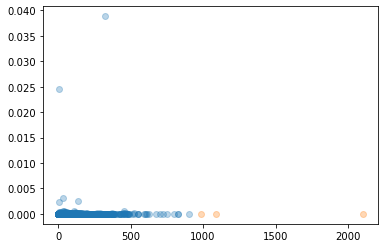

In [64]:
#rewriting our data in a vector in the correct shape for sklearn

Data=np.column_stack((time,flux))

#Defining the scaler and finding the best bandwidth

scaler = preprocessing.StandardScaler()
bandwidth = estimate_bandwidth(Data)
print('bandwidth: ',bandwidth)

#fitting our data

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True,cluster_all=False)
ms.fit(scaler.fit_transform(Data))

#finding the labels and the number of clusters
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])

print('labels: ', labels_unique)
print("number of estimated clusters :", n_clusters)

#predicting the labels of our data

labels = ms.predict(Data)

#plotting showing the found clusters

for i in range(n_clusters):
    plt.scatter(Data[labels==i,0],Data[labels==i,1],alpha=0.3)

bandwidth:  0.9192336206314984
labels:  [-1  0  1  2  3]
number of estimated clusters : 4


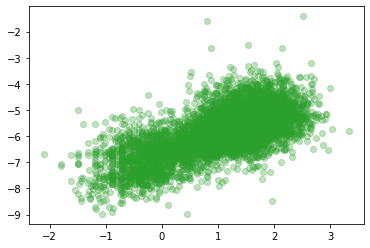

In [67]:
#Doing the same as above taking the log10 of both time and flux

################################################################

#rewriting our data in a vector in the correct shape for sklearn

Data=np.column_stack((np.log10(time),np.log10(flux)))

#Defining the scaler and finding the best bandwidth

scaler = preprocessing.StandardScaler()
bandwidth = estimate_bandwidth(Data)
print('bandwidth: ',bandwidth)

#fitting our data

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True,cluster_all=False)
ms.fit(scaler.fit_transform(Data))

#finding the labels and the number of clusters
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])

print('labels: ', labels_unique)
print("number of estimated clusters :", n_clusters)

#predicting the labels of our data

labels = ms.predict(Data)

#plotting showing the found clusters

for i in range(n_clusters):
    plt.scatter(Data[labels==i,0],Data[labels==i,1],alpha=0.3)

The two results differ a lot from each other, in particular in the bandwidth that the algorithm finds.